In this stage we will perform a grid search usign spark to find the best model for the HLF classifier. We will achieve this by training multiple keras model in parallel.

To run this notebook we used the following configuration:
* *Software stack*: LCG 94 (it has spark 2.3.1)
* *Platform*: centos7-gcc7
* *Spark cluster*: Hadalytic

In [1]:
# Check if Spark Session has been created correctly
spark

## Load train and test datasets

In [2]:
PATH = "hdfs://hadalytic/project/ML/data/swan/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled.parquet')\
        .select(['HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled.parquet')\
        .select(['HLF_input', 'encoded_label'])

In [3]:
test_events = testDF.count()
train_events = trainDF.count()
print('There are {} events in the train dataset'.format(train_events))
print('There are {} events in the test dataset'.format(test_events))

There are 8611 events in the train dataset
There are 2123 events in the test dataset


## Convert to Pandas 

Now we will convert the dataset in a Pandas dataframe in order to be able to use keras

In [4]:
trainDF = trainDF.toPandas()
testDF = testDF.toPandas()

In [5]:
trainDF.head()

,HLF_input,encoded_label
0,"[0.010696109580467801, 0.03581727369726868, 0....","(1.0, 0.0, 0.0)"
1,"[0.011970244990442585, 0.04965804646795174, 0....","(0.0, 0.0, 1.0)"
2,"[0.0557734867199388, 0.08876172563949025, 0.69...","(0.0, 1.0, 0.0)"
3,"[0.10590550120902142, 0.07496635539608656, 0.6...","(0.0, 1.0, 0.0)"
4,"[0.014830885246042046, 0.02531293700524639, 0....","(1.0, 0.0, 0.0)"


We need to convert `Dense` and `Sparse` vectors into list

In [6]:
trainDF[trainDF.columns] = trainDF[trainDF.columns].applymap(lambda x: list(x))
testDF[testDF.columns] = testDF[testDF.columns].applymap(lambda x: list(x))

In [7]:
import numpy as np

X = np.array(trainDF['HLF_input'].tolist())
y = np.array(trainDF['encoded_label'].tolist())

X_test = np.array(testDF['HLF_input'].tolist())
y_test = np.array(testDF['encoded_label'].tolist())

## Create the keras model

In [8]:
from keras.optimizers import adam
from keras.models import Sequential
from keras.layers.core import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

Using TensorFlow backend.


## Create the keras classifier

Wrapping our keras model into a Sklearn classifier allows us to use Sklearn grid Search. We will the distribute the grid search across executors usign Spark-Sklearn.

In [9]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

## Define the grid parameters

In [10]:
batch_size = [100,200]
epochs = [10, 30, 50]

## Number of hidden units per layer
nh_1 = [50,100,150]
nh_2 = [20,50,100]
nh_3 = [10,20,50]

In [11]:
param_grid = {'batch_size':batch_size,
              'epochs':epochs,
              'nh_1':nh_1, 'nh_2':nh_2, 'nh_3':nh_3}

## Grid Search with Spark

In [12]:
from spark_sklearn.grid_search import GridSearchCV

sc = spark.sparkContext

grid = GridSearchCV(sc, estimator=model, param_grid=param_grid, cv=10, verbose=1)

In [13]:
gridSearch_result = grid.fit(X, y)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


In [14]:
# Get the parameters giving the best result
gridSearch_result.best_estimator_.get_params()

{'batch_size': 200,
 'build_fn': <function __main__.create_model>,
 'epochs': 50,
 'nh_1': 150,
 'nh_2': 20,
 'nh_3': 20,
 'verbose': 0}

In [15]:
# See the performance on the test dataset 
y_pred = gridSearch_result.best_estimator_.predict_proba(X_test)

In [16]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [17]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.976597510373444, 1: 0.9838193280474227, 2: 0.9760020855354673}

<IPython.core.display.Javascript object>


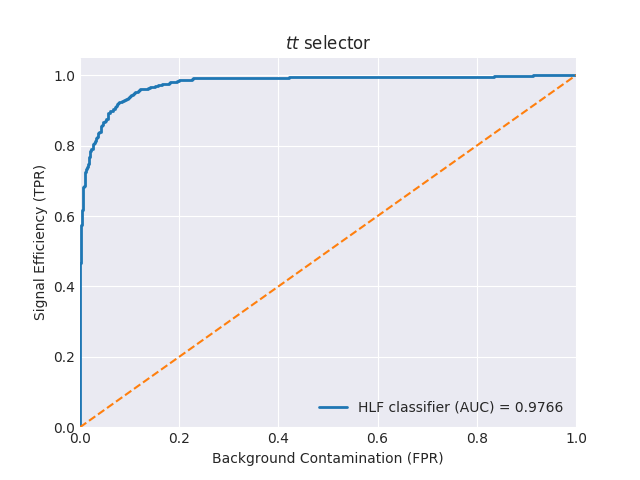

In [19]:
# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib notebook

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()